<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    


### <font color='navy'> Simulación de procesos financieros. 

**Nombres:**  
    
    Estudiante 1. Alexia Marisol Díaz Verduzco     
    Estudiante 2. Marco Antonio Ochoa Cardenas
    
    
**Fecha:** 27 de noviembre de 2021.

**Expedientes** :  
    
    Estudiante 1. if720500  
    Estudiante 2. if720072 
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/AlexiaDiaz/Tarea10.AMDiaz_MOchoa.git

# Tarea 10: Clase 24. Valuación de opciones con barrera


>Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

## Estudiante 1

Código de solución estudiante 1

## Estudiante 2

Código de solución estudiante 2

In [5]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta, date
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [ ]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [ ]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_mt = closes.loc[:,'MSFT']
closes_mt

In [ ]:
closes_mt.plot(figsize=(10,8));
plt.title('Precios Históricos de Microsoft', fontsize=15)
plt.xlabel('Fechas')
plt.ylabel('Precios')
plt.legend();

In [ ]:
closes_mt[-1]###Se muestra último precio de MSFT

### Calculo de rendimientos modelo normal

In [ ]:
ret_mt = calc_daily_ret(closes_mt)###Se guardan los rendimientos en una variable

In [ ]:
mu = ret_mt.mean()
sigma = ret_mt.std()
r = 0.005/360
mu, sigma, r

### Datos de opciones de Microsoft

In [6]:
import requests

def obtener_datos_opciones(symbol):
    headers = headers = {
            'Connection': 'keep-alive',
            'Expires': str(-1),
            'Upgrade-Insecure-Requests': str(1),
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
    }
    url = f'https://query1.finance.yahoo.com/v7/finance/options/{symbol}'
    r = requests.get(url, headers=headers)
    dates = r.json()['optionChain']['result'][0]['expirationDates']
    
    calls = []
    puts = []
    
    for d in dates:
        res = requests.get(url + f'?date={d}', headers=headers)
        calls += res.json()['optionChain']['result'][0]['options'][0]['calls']
        puts += res.json()['optionChain']['result'][0]['options'][0]['puts']

    for c in calls:
        c['type'] = 'call'
        c['lastTradeDate'] = pd.to_datetime(c['lastTradeDate']*1000000000)
        c['expiration'] = pd.to_datetime(c['expiration']*1000000000)
    for p in puts:
        p['type'] = 'put'
        p['lastTradeDate'] = pd.to_datetime(p['lastTradeDate']*1000000000)
        p['expiration'] = pd.to_datetime(p['expiration']*1000000000)
    
    return pd.DataFrame(calls + puts)

In [8]:
msft_opt = obtener_datos_opciones('MSFT')
msft_opt

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
0,MSFT211203C00225000,225.0,USD,...,1.343,True,call
1,MSFT211203C00230000,230.0,USD,...,1.274,True,call
2,MSFT211203C00235000,235.0,USD,...,1.208,True,call
3,MSFT211203C00240000,240.0,USD,...,1.143,True,call
4,MSFT211203C00245000,245.0,USD,...,1.089,True,call
...,...,...,...,...,...,...,...
1861,MSFT240119P00450000,450.0,USD,...,0.262,True,put
1862,MSFT240119P00460000,460.0,USD,...,0.262,True,put
1863,MSFT240119P00470000,470.0,USD,...,0.261,True,put
1864,MSFT240119P00480000,480.0,USD,...,0.260,True,put


### Valuación de opción Barrera Call Down and Out

### Valuación de la opción: comparación Call Europea vs Barrera Call Down and Out

In [11]:
opt_deseada = msft_opt.loc[(msft_opt.type=='call') &  (msft_opt.expiration=='2024-01-19')]
opt_deseada

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
926,MSFT240119C00145000,145.0,USD,...,0.435,True,call
927,MSFT240119C00150000,150.0,USD,...,0.429,True,call
928,MSFT240119C00155000,155.0,USD,...,0.422,True,call
929,MSFT240119C00160000,160.0,USD,...,0.415,True,call
930,MSFT240119C00165000,165.0,USD,...,0.416,True,call
...,...,...,...,...,...,...,...
987,MSFT240119C00460000,460.0,USD,...,0.295,False,call
988,MSFT240119C00470000,470.0,USD,...,0.289,False,call
989,MSFT240119C00480000,480.0,USD,...,0.292,False,call
990,MSFT240119C00490000,490.0,USD,...,0.290,False,call


### Volatility smile

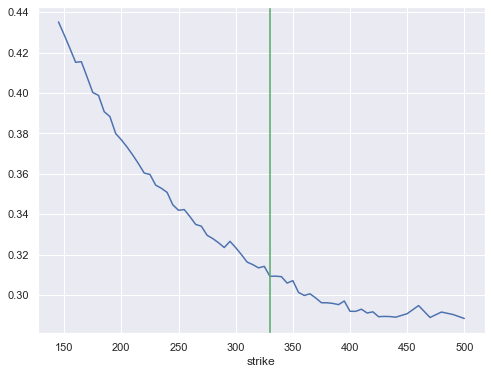

In [13]:
ax = opt_deseada.set_index('strike').loc[:, 'impliedVolatility'].plot(figsize=(8,6))
ax.axvline(329.67, color='g');

In [ ]:
strike = closes_mt.iloc[-1]
strike

In [14]:
strike = 350
opt_deseada = msft_opt.loc[(msft_opt.type=='call') & (msft_opt.strike==strike) & (msft_opt.expiration=='2024-01-19') ]
opt_deseada

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
967,MSFT240119C00350000,350.0,USD,...,0.307,False,call


In [15]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

contractSymbol       MSFT240119C00350000
strike                               350
currency                             USD
lastPrice                           50.9
change                              0.15
                            ...         
expiration           2024-01-19 00:00:00
lastTradeDate        2021-11-26 17:32:02
impliedVolatility                  0.307
inTheMoney                         False
type                                call
Name: 967, Length: 16, dtype: object

In [16]:
opt_valuar['lastPrice']

50.9

### Valuación con modelo normal de precios

In [17]:
K = opt_valuar.strike
S0 = 329.67
K, S0

(350.0, 329.67)

In [18]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expiration

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0
sim_closes


NameError: name 'sigma' is not defined

In [ ]:
# Definir barrera
B = 295
# Crear función indicadora
I = (sim_closes > B).cumprod(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima_Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima_Call_Down_and_Out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot(figsize=[10,8], xlabel='Fechas', ylabel='Precio', title='Comparativa de Primas');
call.plot(ax=ax);

### Valor opción Europea a fecha de expiración

In [ ]:
call.iloc[-1]

### Intervarlos de confianza Europea a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima_Europea
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

El intervalo es cercano a la prima real

### Valor opción Barrera Call Down and Out a fecha de expiración

In [ ]:
callui.iloc[-1]

### Intervarlos de confianza opción Barrera Call Down and Out a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = callui.iloc[-1].Prima_Call_Down_and_Out
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
opt_valuar['lastPrice']

El intervalo en esta evaluacion se acerca aun mas a la prima real

### Valuación con histograma de rendimientos

In [ ]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mt-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expiration

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.strike
S0 = closes_mt.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:] = S0

In [ ]:
# Definir barrera
B = 243
# Crear función indicadora
I = (sim_closes > B).cumprod(axis=0) > 0

# Calcular la prima de una opción Europea
call_hist=pd.DataFrame({'Prima_Europea':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,
                                                                        0).T.mean()},index=dates)
# Calcular la prima de una opción barrera
calliu_hist=pd.DataFrame({'Prima_Call_Down_and_Out':np.exp(-r*ndays)* (I*np.fmax(sim_closes_hist-strike,
                                                         0)).T.mean()},index=dates)

# Graficar el resultado de las dos primas previamente valuadas
ax = calliu_hist.plot(figsize=[10,8], xlabel='Fechas', ylabel='Precio', title='Comparativa de Primas');
call_hist.plot(ax=ax);

### Valor opción Europea a fecha de expiración

In [ ]:
call_hist.iloc[-1]

### Intervarlos de confianza Europea a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima_Europea
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

El intervalo da cerca de la prima real pero menos que con el modelos de los rends normales

### Valor opción Barrera Call Down and Out a fecha de expiración

In [ ]:
calliu_hist.iloc[-1]

### Intervarlos de confianza opción Barrera Call Down and Out a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = calliu_hist.iloc[-1].Prima_Call_Down_and_Out
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
opt_valuar['lastPrice']

La evaluacion con barrera en este caso esta alejada de la prima real

### Valuación de opción Barrera Put Up and Out

### Valuación de la opción: comparación Put Europea vs Barrera Put Up and Out


In [ ]:
opt_deseada = msft_opt.loc[(msft_opt.type=='put') &  (msft_opt.expiration=='2024-01-19')]
opt_deseada

### Volatility smile

In [ ]:
ax = opt_deseada.set_index('strike').loc[:, 'impliedVolatility'].plot(figsize=(8,6))
ax.axvline(329.67, color='g');

In [ ]:
strike = closes_mt.iloc[-1]
strike

In [ ]:
strike = 280
opt_deseada = msft_opt.loc[(msft_opt.type=='put') & (msft_opt.strike==strike) & (msft_opt.expiration=='2024-01-19') ]
opt_deseada

In [ ]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

In [ ]:
opt_valuar['lastPrice']

### Valuación con modelo normal de precios

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expiration

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0

In [ ]:
# Definir barrera
B = 380
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima_Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima_Put_Up_and_Out':np.exp(-r*ndays)*(I * np.fmax(strike - sim_closes , 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot(figsize=[10,8], xlabel='Fechas', ylabel='Precio', title='Comparativa de Primas');
put.plot(ax=ax);

### Valor opción Europea a fecha de expiración

In [ ]:
put.iloc[-1]

### Intervarlos de confianza Europea a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima_Europea
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

El intervalo se acerca a la prima real

### Valor opción Barrera Put Up and Out a fecha de expiración

In [ ]:
putui.iloc[-1]

### Intervarlos de confianza opción Barrera Put Up and Out a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = putui.iloc[-1].Prima_Put_Up_and_Out
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
opt_valuar['lastPrice']

Esta mas alejado que con el otro modelo, tiene sentido debido a ue si la barrera es menor hay mas riesgo y la prima es mas barata

### Valuación con histograma de rendimientos

In [ ]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mt-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expiration

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.strike
S0 = closes_mt.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:] = S0

In [ ]:
# Definir barrera
B = 380
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0) > 0

# Calcular la prima de una opción Europea
put_hist=pd.DataFrame({'Prima_Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist, 0).T.mean()},index=dates)
# Calcular la prima de una opción barrera
putiu_hist=pd.DataFrame({'Prima_Put_Up_and_Out':np.exp(-r*ndays)* (I * np.fmax(strike - sim_closes_hist, 0)).T.mean()},index=dates)

# Graficar el resultado de las dos primas previamente valuadas
ax = putiu_hist.plot(figsize=[10,8], xlabel='Fechas', ylabel='Precio', title='Comparativa de Primas');
put_hist.plot(ax=ax);

### Valor opción Europea a fecha de expiración

In [ ]:
put_hist.iloc[-1]

### Intervarlos de confianza Europea a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima_Europea
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

El intervalo es cercano a la prima pero menos certero que el de rends normales

### Valor opción Barrera Put Up and Out a fecha de expiración

In [ ]:
putiu_hist.iloc[-1]

Intervarlos de confianza opción Barrera Put Up and Out a fecha de expiración

In [ ]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = putiu_hist.iloc[-1].Prima_Put_Up_and_Out
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
opt_valuar['lastPrice']

La valuacion es menor que la valuacion real de la opcion